# lmm.ipynb

Notebook to apply LMM to control for clade relationships in virus-infected strains when quantifying differential expression

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/qk/0d5w_j9s6t995z3rw3hfgjmm0000gn/T/ipykernel_27915/2959005546.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


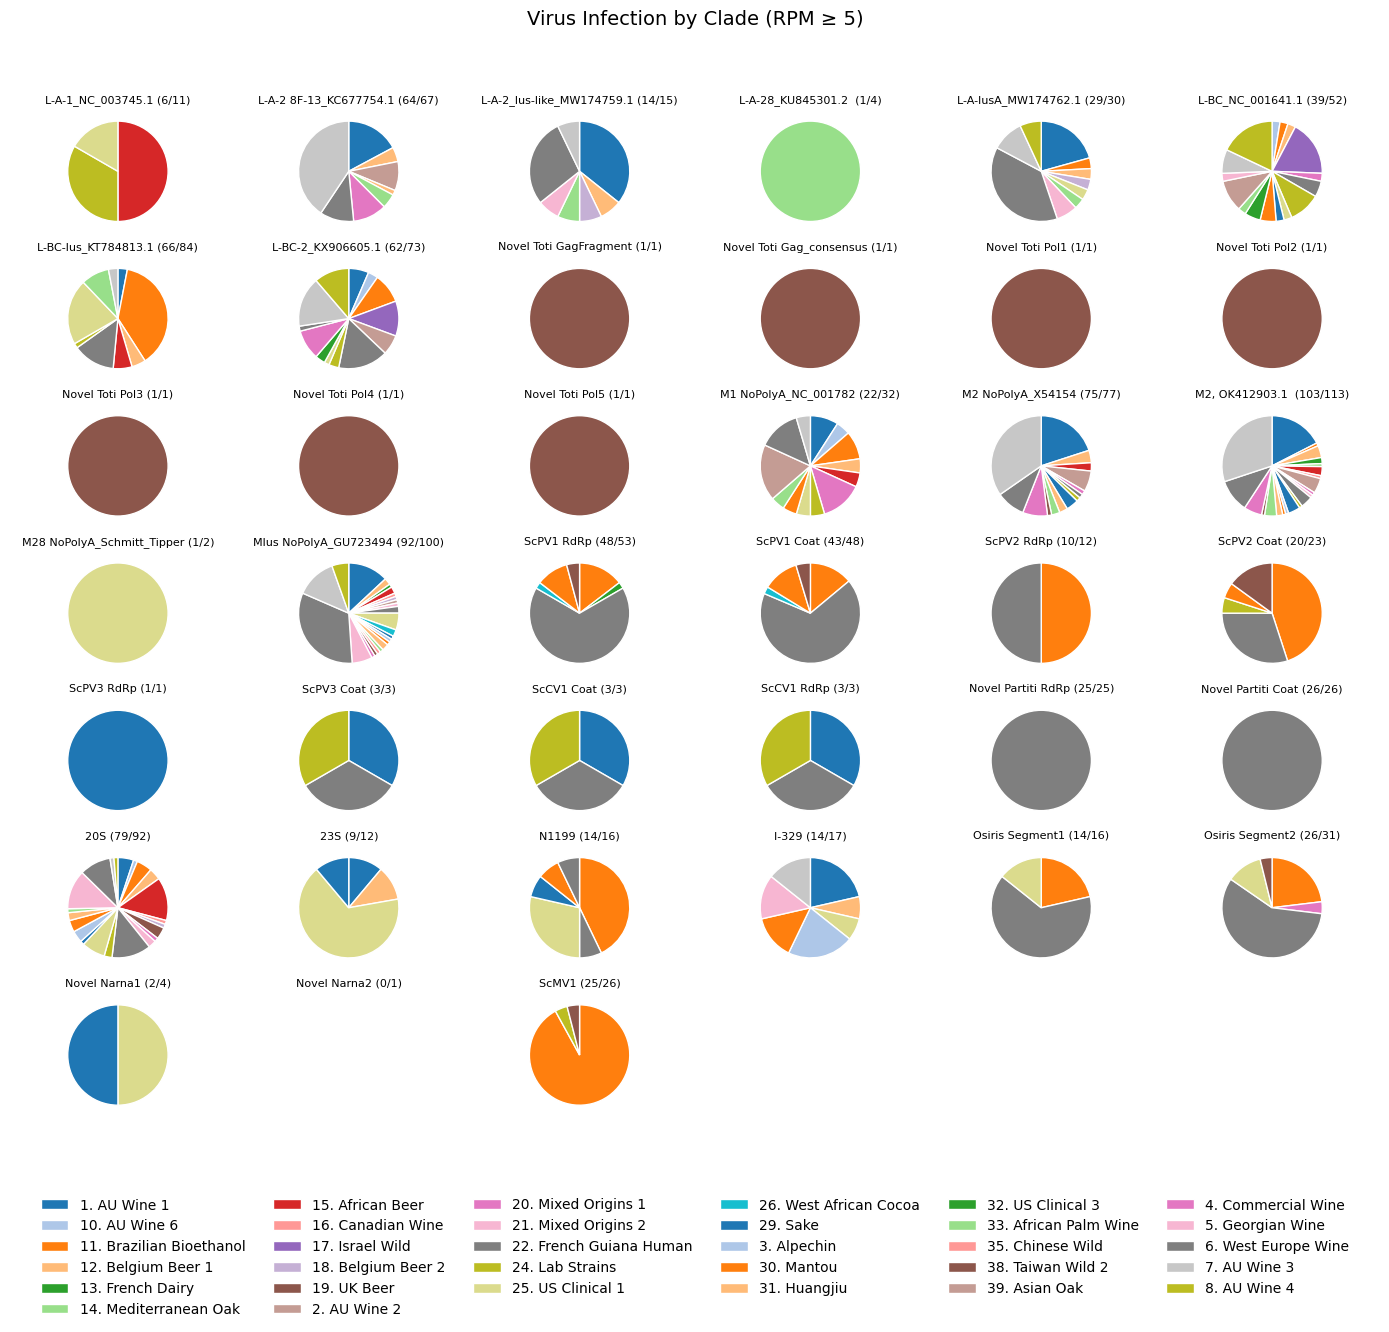

In [324]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from pathlib import Path
from matplotlib.patches import Patch

def plot_virus_infection_pies(
    virome_path="data/virome250531.tsv",
    clade_path="data/strain_ecodata.csv",
    map_path="data/rnaseq_accessions.tsv",
    min_rpm=5.0,
    max_cols=6,
    figsize=(14, 12)
):
    """
    Plot per-virus pie charts showing clade composition of infected strains (RPM ≥ threshold).
    """

    # Load data
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    virome = pd.read_csv(virome_path, sep="\t", dtype=str)
    clade_df = pd.read_csv(clade_path)

    # Fix numeric conversion
    virome.iloc[:, 1:] = virome.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

    # Merge all metadata
    merged = virome.merge(mapper[["accession", "std_name"]], on="accession", how="inner")
    merged = merged.merge(clade_df[["std_name", "Clade"]].rename(columns={"Clade": "clade"}), on="std_name", how="left")

    virus_cols = [col for col in merged.columns if col not in {"accession", "std_name", "clade"}]
    clades = sorted(merged["clade"].dropna().unique())
    cmap = get_cmap("tab20")
    clade_colors = {clade: cmap(i % 20) for i, clade in enumerate(clades)}

    # Track which clades are used (for legend)
    clades_used = set()

    # Layout
    n = len(virus_cols)
    ncols = min(n, max_cols)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()

    for i, virus in enumerate(virus_cols):
        df = merged[["std_name", "clade", virus]].copy()
        df["infected"] = df[virus] >= min_rpm
        infected = df[df["infected"]]

        # Count by clade
        clade_counts = infected["clade"].value_counts().sort_index()
        labels = clade_counts.index.tolist()
        sizes = clade_counts.values
        colors = [clade_colors.get(c, "gray") for c in labels]
        clades_used.update(labels)

        ax = axs[i]
        ax.pie(
            sizes,
            colors=colors,
            startangle=90,
            counterclock=False,
            wedgeprops={"edgecolor": "white"}
        )

        # Title: Virus (N_in_clade / N_total_infected)
        n_infected = len(infected)
        n_in_clade = clade_counts.sum()
        ax.set_title(f"{virus} ({n_in_clade}/{n_infected})", fontsize=8, pad=10)
        ax.axis("equal")

    # Clean up unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Legend: horizontal below the plot
    legend_elements = [
        Patch(facecolor=clade_colors[clade], edgecolor="white", label=clade)
        for clade in sorted(clades_used)
    ]

    fig.subplots_adjust(bottom=0.2)  # reserve space
    fig.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0),   # push completely outside
        ncol=6,
        fontsize=10,
        frameon=False
    )

    fig.suptitle(f"Virus Infection by Clade (RPM ≥ {min_rpm})", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space at bottom for legend
    plt.show()

# === Call it
plot_virus_infection_pies(min_rpm=5)

In [300]:
counts = pd.read_csv("data/count_matrix.csv.gz", index_col=0)
print(counts.shape)
print(counts.iloc[:5, :5])

(6454, 969)
                                AAA     AAB  AAD  AAE  AAG
systematic_name                                           
X1-EC1118_1F14_0012g            0.0    25.0  0.0  0.0  0.0
X10-EC1118_1F14_0133g           0.0  1368.0  0.0  0.0  0.0
X1003-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1004-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1005-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0


In [3]:
# Library size per strain (column)
lib_size = counts.sum(axis=0)
# Counts per million
cpm = counts.div(lib_size, axis=1) * 1e6
# Log2-transformed CPM + 1
logcpm = np.log2(cpm + 1)
logcpm.index.name = "gene"
logcpm.head()


,AAA,AAB,AAD,AAE,AAG,AAH,AAI,AAK,AAL,AAM,...,XTRA_DGX,XTRA_DGY,XTRA_DHB,XTRA_DHD,XTRA_DHE,XTRA_DHJ,XTRA_DHK,XTRA_DHO,XTRA_DHQ,XTRA_DXL
gene,,,,,,,,,,,,,,,,,,,,,
X1-EC1118_1F14_0012g,0.0,3.191946,0.0,0.0,0.0,3.994808,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10-EC1118_1F14_0133g,0.0,8.801982,0.0,0.0,0.0,4.213928,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1003-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1004-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1005-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Reshape to long format
long_df = (
    logcpm
    .reset_index()
    .melt(id_vars="gene", var_name="strain", value_name="logcpm")
)
long_df.head()


,gene,strain,logcpm
0,X1-EC1118_1F14_0012g,AAA,0.0
1,X10-EC1118_1F14_0133g,AAA,0.0
2,X1003-augustus_masked.YCM.7680,AAA,0.0
3,X1004-augustus_masked.YCM.7680,AAA,0.0
4,X1005-augustus_masked.YCM.7680,AAA,0.0


In [332]:
def load_virome_infection_status(path_virome, target_virus_name, min_rpm=5.0, map_path="data/rnaseq_accessions.tsv"):
    """
    Load virome RPM matrix and return 3-letter strain infection status for a given virus.
    
    Parameters:
        path_virome (str/Path): Path to the virome RPM table (e.g., virome250531.tsv)
        target_virus_name (str): Column name for the virus (must match exactly)
        min_rpm (float): RPM threshold to call 'infected' (default=5.0)
        map_path (str/Path): Path to accession→std_name mapping file (e.g., rnaseq_accessions.tsv)
        
    Returns:
        pd.DataFrame with columns: ['std_name', 'infected']
    """
    path_virome = Path(path_virome)
    map_path = Path(map_path)

    # Load mapping (accession → std_name)
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    if "accession" not in mapper.columns or "std_name" not in mapper.columns:
        raise ValueError("Mapping file must contain 'accession' and 'std_name' columns.")

    # Load virome matrix
    df = pd.read_csv(path_virome, sep="\t", dtype=str)
    df[target_virus_name] = pd.to_numeric(df[target_virus_name], errors='coerce')

    if target_virus_name not in df.columns:
        raise ValueError(f"Virus '{target_virus_name}' not found in virome file columns.")

    # Merge with mapper to get std_name
    merged = df.merge(mapper[["accession", "std_name"]], on="accession", how="inner")

    # Assign infection status
    out = pd.DataFrame({
        "std_name": merged["std_name"],
        "infected": (merged[target_virus_name] >= min_rpm).astype(int)
    })

    return out

def load_clade_mapping(path="data/strain_ecodata.csv"):
    """
    Load strain-to-clade mapping from strain_ecodata.csv.
    
    Returns:
        DataFrame with columns: ['std_name', 'clade']
    """
    df = pd.read_csv(path)
    if "std_name" not in df.columns or "Clade" not in df.columns:
        raise ValueError("strain_ecodata.csv must contain 'std_name' and 'Clade' columns.")
    
    clade_df = df[["std_name", "Clade"]].rename(columns={"Clade": "clade"}).dropna()
    clade_df["clade"] = clade_df["clade"].astype(str).str.strip()
    return clade_df

def build_metadata(virome_path, virus, min_rpm=5.0, clade_path="data/strain_ecodata.csv"):
    """
    Assemble metadata with ['std_name', 'infected', 'clade'].

    Parameters:
        virome_path (str): path to virome RPM matrix
        virus (str): virus column name
        min_rpm (float): infection threshold
        clade_path (str): path to strain_ecodata.csv

    Returns:
        pd.DataFrame with std_name, infected, clade
    """
    infection_df = load_virome_infection_status(virome_path, virus, min_rpm)
    clade_df = load_clade_mapping(clade_path)
    
    meta = infection_df.merge(clade_df, on="std_name", how="inner")
    meta = meta[["std_name", "infected", "clade"]]
    return meta


# Define virus of interest
virus = "ScPV1 RdRp"

meta = build_metadata(
    virome_path="data/virome250531.tsv",
    virus=virus,
    min_rpm=5,
    clade_path="data/strain_ecodata.csv"
)
meta.head()


,std_name,infected,clade
0,AAB,0,12. Belgium Beer 1
1,AAD,0,29. Sake
2,AAE,0,5. Georgian Wine
3,AAI,0,1. AU Wine 1
4,AAK,0,5. Georgian Wine


In [333]:
# =============================
# Linear Mixed Model Pipeline
# =============================

import pandas as pd
import numpy as np
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific model warnings
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*divide by zero.*", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*invalid value encountered.*", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*Random effects covariance is singular.*", category=UserWarning)

# -------------------------------
# Core: Single-gene model fitting
# -------------------------------

def _fit_lmm_per_gene(gene: str, dfg: pd.DataFrame, outcome: str, predictor: str, group: str) -> dict:
    """
    Fit a mixed linear model for a single gene.

    Parameters:
        gene: gene identifier
        dfg: subset dataframe for this gene
        outcome: response variable (e.g., 'logcpm')
        predictor: binary variable of interest (e.g., 'infected')
        group: random effect grouping (e.g., 'clade')

    Returns:
        Dictionary with gene, beta, pval
    """
    # Suppress inside each subprocess
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.filterwarnings("ignore", message=".*divide by zero.*", category=RuntimeWarning)
    warnings.filterwarnings("ignore", message=".*invalid value encountered.*", category=RuntimeWarning)
    warnings.filterwarnings("ignore", message=".*Random effects covariance is singular.*", category=UserWarning)
    
    if dfg[predictor].nunique() < 2:
        return {"gene": gene, "beta": np.nan, "pval": np.nan}

    try:
        model = mixedlm(f"{outcome} ~ {predictor}", dfg, groups=dfg[group])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            fit = model.fit(reml=False)
        return {
            "gene": gene,
            "beta": fit.params.get(predictor, np.nan),
            "pval": fit.pvalues.get(predictor, np.nan)
        }
    except Exception:
        return {"gene": gene, "beta": np.nan, "pval": np.nan}

# -------------------------------
# Public API: Parallel LMM runner
# -------------------------------

def run_lmm_joblib(long_df: pd.DataFrame,
                   meta_df: pd.DataFrame,
                   outcome: str = "logcpm",
                   predictor: str = "infected",
                   group: str = "clade",
                   strain_col: str = "strain",
                   meta_strain_col: str = "std_name",
                   n_jobs: int = 8) -> pd.DataFrame:
    """
    Run per-gene linear mixed models in parallel using joblib.

    Parameters:
        long_df: DataFrame with ['gene', strain_col, outcome]
        meta_df: DataFrame with [meta_strain_col, predictor, group]
        outcome: name of outcome column (default 'logcpm')
        predictor: name of binary predictor column (default 'infected')
        group: name of random effect group (default 'clade')
        strain_col: name of strain ID column in long_df
        meta_strain_col: name of strain ID column in meta_df
        n_jobs: number of parallel workers

    Returns:
        DataFrame with ['gene', 'beta', 'pval', 'fdr']
    """

    # Merge strain metadata
    df = long_df.merge(
        meta_df[[meta_strain_col, predictor, group]],
        left_on=strain_col,
        right_on=meta_strain_col,
        how="inner"
    )

    # Drop missing values in relevant columns
    df = df[[ "gene", outcome, predictor, group ]].dropna()

    # Parallelized model fitting
    grouped = list(df.groupby("gene"))
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_fit_lmm_per_gene)(gene, dfg, outcome, predictor, group)
        for gene, dfg in tqdm(grouped, desc="Running LMMs")
    )

    res_df = pd.DataFrame(results)

    # Multiple testing correction
    if not res_df["pval"].isnull().all():
        res_df["fdr"] = multipletests(res_df["pval"], method="fdr_bh")[1]
    else:
        res_df["fdr"] = np.nan

    return res_df

# Filter clades with fewer than N members
min_clade_members = 5
valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
meta = meta[meta["clade"].isin(valid_clades)]

results = run_lmm_joblib(long_df, meta, n_jobs=8)
results.head()

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

,gene,beta,pval,fdr
0,X1-EC1118_1F14_0012g,-0.047916,0.766837,NaN
1,X10-EC1118_1F14_0133g,-0.072027,0.748376,NaN
2,X1003-augustus_masked.YCM.7680,-0.196055,0.000581,NaN
3,X1004-augustus_masked.YCM.7680,-0.153902,0.000594,NaN
4,X1005-augustus_masked.YCM.7680,-0.221268,0.001207,NaN


In [334]:
import re

# Yeast ORF pattern: e.g. YBR123C, YGL255W-A
orf_pattern = re.compile(r"^Y[A-P][LRM][0-9]{3}[WC](?:-[A-Z])?$")

# Keep only rows where 'gene' matches ORF pattern
results_orfs = results[results["gene"].apply(lambda g: bool(orf_pattern.match(g)))].copy()

print(f"[i] Filtered to {len(results_orfs)} systematic ORFs from {len(results)} total genes.")
results_orfs.head()

[i] Filtered to 6088 systematic ORFs from 6454 total genes.


,gene,beta,pval,fdr
366,YAL001C,-0.018096,0.803555,NaN
367,YAL002W,0.011234,0.872735,NaN
368,YAL003W,-0.125825,0.152925,NaN
369,YAL005C,0.184096,0.281252,NaN
370,YAL007C,-0.120699,0.152775,NaN


In [335]:
import json

import json
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

def enrich_lmm_results(results_df, sys2std_path, sys2desc_path):
    """
    Enrich LMM results with gene name and description.
    
    Parameters:
        results_df: pd.DataFrame with 'gene' column (systematic name)
        sys2std_path: Path to JSON mapping of sys → std gene names
        sys2desc_path: Path to JSON mapping of sys → gene description
        
    Returns:
        DataFrame with columns: gene, std_gene, description, label, beta, pval, fdr
    """
    # Load mappings
    with open(sys2std_path, encoding='utf-8') as f:
        sys_to_std = json.load(f)
    with open(sys2desc_path, encoding='utf-8') as f:
        sys_to_desc = json.load(f)

    # Filter valid ORFs
    df = results_df[~results_df["gene"].str.contains("_")].copy()

    # Add name/desc
    df["std_gene"] = df["gene"].map(sys_to_std).fillna(df["gene"])
    df["description"] = df["gene"].map(sys_to_desc).fillna("")

    # Label format
    df["label"] = np.where(df["std_gene"] != df["gene"],
                           df["std_gene"] + " (" + df["gene"] + ")",
                           df["gene"])

    # Recompute FDR if needed
    if "fdr" not in df.columns or df["fdr"].isnull().all():
        valid_p = df["pval"].dropna()
        fdr = pd.Series(np.nan, index=df.index)
        if not valid_p.empty:
            fdr_vals = multipletests(valid_p.values, method="fdr_bh")[1]
            fdr.loc[valid_p.index] = fdr_vals
        df["fdr"] = fdr

    return df[["gene", "std_gene", "description", "label", "beta", "pval", "fdr"]]


# Paths to your JSON files
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

# Your LMM result DataFrame (from `run_lmm_from_strainmeta`)
enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
enriched = enriched.sort_values('beta', ascending=False)
enriched.head()


,gene,std_gene,description,label,beta,pval,fdr
1428,YDR133C,YDR133C,Dubious open reading frame; unlikely to encode...,YDR133C,2.007907,2.089643e-02,2.637573e-01
2182,YFL056C,AAD6,Putative aryl-alcohol dehydrogenase; involved ...,AAD6 (YFL056C),1.783096,2.371323e-10,7.218307e-07
1808,YDR517W,GRH1,"Acetylated cis-Golgi protein, homolog of human...",GRH1 (YDR517W),1.631051,3.668933e-03,1.358534e-01
2499,YGL255W,ZRT1,High-affinity zinc transporter of the plasma m...,ZRT1 (YGL255W),1.497056,1.257494e-02,2.263315e-01
1044,YCR098C,GIT1,Plasma membrane permease; mediates uptake of g...,GIT1 (YCR098C),1.427119,9.250826e-05,1.816743e-02


In [340]:
# ---------------------
# Config: Filter Options
# ---------------------
LFC_FILTER = "up"    # options: "up", "down", or None
FDR_THRESH = 0.25
LFC_CUTOFF = 0.5     # absolute log2 fold change threshold

# ---------------------
# Apply Filter
# ---------------------
filtered = enriched.copy()
if LFC_FILTER == "up":
    filtered = filtered[
        (filtered["fdr"].notna()) &
        (filtered["fdr"] < FDR_THRESH) &
        (filtered["beta"] >= LFC_CUTOFF)
    ]
elif LFC_FILTER == "down":
    filtered = filtered[
        (filtered["fdr"].notna()) &
        (filtered["fdr"] < FDR_THRESH) &
        (filtered["beta"] <= -LFC_CUTOFF)
    ].sort_values('beta')
elif LFC_FILTER is None:
    filtered = filtered[
        (filtered["fdr"].notna()) &
        (filtered["fdr"] < FDR_THRESH)
    ]
else:
    raise ValueError("LFC_FILTER must be 'up', 'down', or None")

# ---------------------
# Preview — styled with wrapped description
# ---------------------
# Export as CSV
filtered.to_csv(f'~/Desktop/{virus.lower().replace(' ', '_')}_sig_{LFC_FILTER}reg_genes.csv', index=False)

filtered[['label', 'description', 'beta', 'fdr']].head(15).style.set_properties(subset=['description'], **{
    'white-space': 'pre-wrap',
    'word-wrap': 'break-word',
    'max-width': '800px'
})


,label,description,beta,fdr
2182,AAD6 (YFL056C),"Putative aryl-alcohol dehydrogenase; involved in oxidative stress response; similar to P. chrysosporium aryl-alcohol dehydrogenase; ORFs AAD6/YFL056C and AAD16/YFL057C are displaced from one another by -1 frameshift; members of the AAD gene family comprise three pairs (AAD3 + AAD15, AAD6/AAD16 + AAD4, AAD10 + AAD14) whose two genes are more related to one another than to other members of the family; expression induced in cells treated with the mycotoxin patulin",1.783096,0.000001
1808,GRH1 (YDR517W),"Acetylated cis-Golgi protein, homolog of human GRASP65; forms a complex with the coiled-coil protein Bug1p; required for unconventional protein secretion (UPS) of Acb1p in response to starvation; forms amyloid fibrils under heat shock; protein abundance increases in response to DNA replication stress",1.631051,0.135853
2499,ZRT1 (YGL255W),High-affinity zinc transporter of the plasma membrane; responsible for the majority of zinc uptake; transcription is induced under low-zinc conditions by the Zap1p transcription factor,1.497056,0.226332
1044,GIT1 (YCR098C),Plasma membrane permease; mediates uptake of glycerophosphoinositol and glycerophosphocholine as sources of the nutrients inositol and phosphate; expression and transport rate are regulated by phosphate and inositol availability,1.427119,0.018167
2252,IRC7 (YFR055W),"Cysteine desulphydrase, enables growth on cysteine as nitrogen source; involved in the production of thiols; null mutant displays increased levels of spontaneous Rad52p foci; expression induced by nitrogen limitation in a GLN3, GAT1-dependent manner and by copper levels in a Mac1-dependent manner",1.366589,0.010861
2180,AQY3 (YFL054C),Putative channel-like protein; similar to Fps1p; mediates passive diffusion of glycerol in the presence of ethanol,1.348695,0.056191
2178,ZNF1 (YFL052W),"Zinc cluster transcription factor that regulates respiratory growth; binds to promoters of genes involved in respiration, gluconeogenesis, and the glyoxylate shunt; required for normal carbon source utilization and adaptation to pH, osmotic and ethanol stress especially during non-fermentative metabolism",1.233404,0.181031
4527,YLR460C,Member of the quinone oxidoreductase family; up-regulated in response to the fungicide mancozeb; possibly up-regulated by iodine,1.100018,0.000741
2251,HXK1 (YFR053C),"Hexokinase isoenzyme 1; a cytosolic protein that catalyzes phosphorylation of glucose during glucose metabolism; expression is highest during growth on non-glucose carbon sources; glucose-induced repression involves hexokinase Hxk2p; HXK1 has a paralog, HXK2, that arose from the whole genome duplication",1.094468,0.051982
2179,DAK2 (YFL053W),Dihydroxyacetone kinase; required for detoxification of dihydroxyacetone (DHA); involved in stress adaptation,1.081978,0.061628


In [341]:
ranks = filtered.dropna(subset=["beta"]).set_index("gene")["beta"].sort_values(ascending=False)
ranks

gene
YFL056C    1.783096
YDR517W    1.631051
YGL255W    1.497056
YCR098C    1.427119
YFR055W    1.366589
             ...   
YLL067C    0.519618
YFL068W    0.516883
YLL056C    0.512123
YCR099C    0.506068
YMR196W    0.503756
Name: beta, Length: 66, dtype: float64

In [342]:
from scipy.stats import hypergeom
import json

# ------------------------
# Config
# ------------------------
GO_JSON = "data/annotations/go_bp.json"

# ------------------------
# Load GO BP
# ------------------------
with open(GO_JSON, encoding="utf-8") as f:
    go_bp = json.load(f)

# ------------------------
# Prepare sets
# ------------------------
all_genes = set(results_orfs.gene)
top_genes = set(ranks.index)

# ------------------------
# Hypergeometric Test
# ------------------------
hits = []
M = len(all_genes)  # total genes tested
n = len(top_genes)  # top hits

for go_id, entry in go_bp.items():
    genes = set(entry["genes"])
    k = len(genes & top_genes)      # hits in top
    N = len(genes & all_genes)      # hits in background

    if k > 0 and N > 0:
        pval = hypergeom.sf(k - 1, M, N, n)
        hits.append({
            "go_id": go_id,
            "name": entry["name"],
            "overlap": k,
            "term_size": N,
            "pval": pval,
        })

# ------------------------
# Results DataFrame
# ------------------------
hits_df = pd.DataFrame(hits)
hits_df = hits_df[(hits_df["term_size"] >= 4) & (hits_df["term_size"] <= 75)].copy()
if not hits_df.empty and hits_df["pval"].notna().any():
    hits_df["fdr"] = multipletests(hits_df["pval"], method="fdr_bh")[1]
else:
    hits_df["fdr"] = np.nan
hits_df = hits_df[(hits_df['fdr'] < 0.15) & ((hits_df['overlap'] > 1))]
hits_df = hits_df.sort_values("fdr").reset_index(drop=True)

# ------------------------
# Print header
# ------------------------
# Compute true FC from log2 scale
true_fc = 2 ** LFC_CUTOFF

if LFC_FILTER == "up":
    fc_str = f"≥ {true_fc:.2f}×"
elif LFC_FILTER == "down":
    fc_str = f"≤ {1 / true_fc:.2f}×"
else:
    fc_str = f"± {true_fc:.2f}×"

print("=" * 80)
print(f"[{virus}] GO BP Enrichment Analysis")
print(f"Filtering: LFC direction = {LFC_FILTER or 'none'}, "
      f"log2FC threshold = {LFC_CUTOFF:.2f} (fold change {fc_str}), "
      f"FDR < {FDR_THRESH}")
print("=" * 80)

# ------------------------
# Preview top enriched terms
# ------------------------
hits_df.sort_values('fdr').head(25)

[ScPV1 RdRp] GO BP Enrichment Analysis
Filtering: LFC direction = up, log2FC threshold = 0.50 (fold change ≥ 1.41×), FDR < 0.25


,go_id,name,overlap,term_size,pval,fdr
0,GO:0000722,telomere maintenance via recombination,9,40,2.472212e-10,1.606937e-08
1,GO:0000023,maltose metabolic process,4,12,5.843760e-06,1.899222e-04
2,GO:0000025,maltose catabolic process,3,5,1.198555e-05,2.596868e-04
3,GO:0005987,sucrose catabolic process,3,6,2.378510e-05,3.092063e-04
4,GO:0046352,disaccharide catabolic process,3,6,2.378510e-05,3.092063e-04
5,GO:0000128,flocculation,2,6,1.688352e-03,1.829048e-02
6,GO:0000256,allantoin catabolic process,2,7,2.347172e-03,2.179517e-02
7,GO:0051156,glucose 6-phosphate metabolic process,2,8,3.107707e-03,2.244455e-02
8,GO:0006144,purine nucleobase metabolic process,2,8,3.107707e-03,2.244455e-02
9,GO:0006098,pentose-phosphate shunt,2,13,8.359755e-03,5.433841e-02
